# Doctors' Recommendations (based on surgical follow-up rates)

## The problem setting

Choose which doctor to recommend to new patients given the doctors' past performance data. The quality metric is the number of patients needing a follow-up surgery (a second surgery). Data:
| Doctor  | Follow-ups | Total Surgeries | Follow-up Rate |
|---------|------------|-----------------|----------------|
| A       | 60         | 200             | 0.30 (30%)     |
| B       | 5          | 20              | 0.25 (25%)     |

## We discussed the follwong:

1. Formally <span style="color:red">__test statistical (in)significance__</span>.
    - It looks like there is no statistically significant difference.
2. Try <span style="color:red">__Bayesian approach__</span>
    - Gives us more perspective to consider our choice.
    - Can be _easily and naturally_ iteratively updated as we geather more data.
3. <span style="color:red">Resample (Bootstrap)</span>
    - Avoid making assumption about the underlying distibution.
4. Run a <span style="color:red">simulation</span>
    - Same reason: analytical formulas assume asymptotic normality, which may be shaky for small samples (Doctor B); simulation lets us see empirical coverage, CI width, and the effect of imbalance)
5. It is important to understand __what is considered a good quality__:
    - e.g., if a good quality is 10%, then both doctors are not good and we have  a high confidence that __A__ is not good and hence should not be recommended.
    - e.g., if a good quality is 50%, then the conclusion and our recommendation is opposite: recommend __A__ with high confidence.
6. Business-wise, even if our confidence is high, it can make sense to combine "__exploitation__" (i.e., recommending a good solution for which we have high confidence) with __exploration__ (i.e., sometimes recommending a doctor with less observations) to get more data and potentially extend the pool of available doctors. The exploration rate can be set, e.g., to 10% with exploitations being 90%.

## The main issue and how to handle it

The main issue is the imbalanced sample sizes, and we can try the following approaches.
| Method                          | Description                                                         | Pros                                    | Cons                                 |
|--------------------------------|----------------------------|-----------------------------------------|--------------------------------------|
| **Get more data on Dr _B_** | $\uparrow$ sample size to $\downarrow$ variance | Most reliable | Time, Cost |
| <span style="color:red">**Bayesian methods**</span> | Incorporate prior knowledge; posteriors  handle noise | Handles small samples better | Need prior assumptions|
| <span style="color:red">**Resample**</span> | Bootstrap small group | Balances influence | Can bias results |
| **Propensity score matching** | Adjust for patient differences to compare similar groups | More fair comparisons | Needs additional patient data |
| **Report with caution** | Communicate uncertainty | Transparency | Doesn't solve the problem |

# I. Statistical Analysis Steps

We need to comparing two **binomial proportions** and test if difference in follow-up rates is statistically significant.


### Hypotheses
- $H_0: p_A = p_B$ (no difference)
- $H_1: p_A\neq p_B$ (difference exists)

### Let's use the Two-Proportion Z-Test:
$$Z = \frac{p_A - p_B}{\sqrt{p(1-p)\left(\frac{1}{n_A} + \frac{1}{n_B}\right)}}$$

Where:
- $p_A = \frac{60}{200} = 0.30$
- $p_B = \frac{5}{20} = 0.25$
- $p = \frac{60+5}{200+20} = \frac{65}{220} \approx 0.2955$

Hence: $Z={0.05\over0.107}\approx 0.467.$

### Conclusion (interpreting Z-score)
Assuming we are interested in 95% CI (i.e. $Z\in\pm 1.96$), since $0.467 \in (-1.96, 1.96)$ we **fail to reject \(H_0\)**, i.e. `No statistically significant difference.`


### CI for Difference
$$(p_A - p_B) \pm 1.96\times \sqrt{\frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B}} = 0.05 \pm 0.20$$
CI: $[-0.15, 0.25]$ - since it includes zero, there is `no significant difference`.

### Sample Size Imbalance
Doctor B’s small sample size (20) results in **high uncertainty**, i.e. estimates are less reliable.

### Summary
1. **No conclusive evidence one doctor is better.**
2. Doctor A's estimate is more stable due to larger sample.
3. Doctor B's better rate might be noise.
4. Collect more data on Doctor B or consider other factors.
5. Bayesian methods or advanced modeling can help handle uncertainty better. (_see below_)

---
# II. Bayesian Approach

_Bayesian approach better handles small sample uncertainty and gives richer insight._

We model the follow-up counts as binomial with unknown probabilities $p_A$ and $p_B$:
$$x_i \sim \mathsf{Binomial}(n_i, p_i), \quad i \in \{A,B\}$$

Place Beta priors on \(p_i\): $$p_i \sim \mathsf{Beta}(\alpha, \beta)$$

Update to posterior given data: $$p_i | x_i, n_i \sim \mathsf{Beta}(\alpha + x_i, \beta + n_i - x_i)$$

Key points:
- Use __uniform prior__ $\mathsf{Beta}(1,1)$ if no prior info.
- Posteriors: DrA $\sim\mathsf{Beta}(1 + 60, 1 + 140)$, DrB $\sim\mathsf{Beta}(1 + 5, 1 + 15)$
- Sample from these posteriors to estimate distributions and credible intervals.
- Compute probability DrB is better: $\mathbb{P}(p_B < p_A)$.

Posterior mean Doctor A follow-up rate: 0.302
Posterior mean Doctor B follow-up rate: 0.273


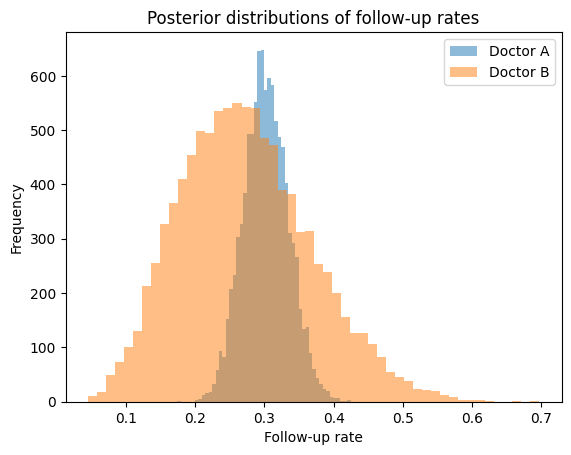

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Data
xA, nA = 60, 200
xB, nB = 5, 20

# Prior parameters (uniform)
alpha_prior, beta_prior = 1, 1

# Posterior parameters
alphaA_post = alpha_prior + xA
betaA_post = beta_prior + nA - xA

alphaB_post = alpha_prior + xB
betaB_post = beta_prior + nB - xB

# Sampling from posterior
N_samples = 10000
pA_samples = beta.rvs(alphaA_post, betaA_post, size=N_samples)
pB_samples = beta.rvs(alphaB_post, betaB_post, size=N_samples)
print(f"Posterior mean Doctor A follow-up rate: {np.mean(pA_samples):.3f}")
print(f"Posterior mean Doctor B follow-up rate: {np.mean(pB_samples):.3f}")
# Plot posterior distributions
plt.hist(pA_samples, bins=50, alpha=0.5, label='Doctor A')
plt.hist(pB_samples, bins=50, alpha=0.5, label='Doctor B')
plt.xlabel('Follow-up rate')
plt.ylabel('Frequency')
plt.title('Posterior distributions of follow-up rates')
plt.legend()
plt.show()

Probability Doctor B better (lower follow-up): 0.639


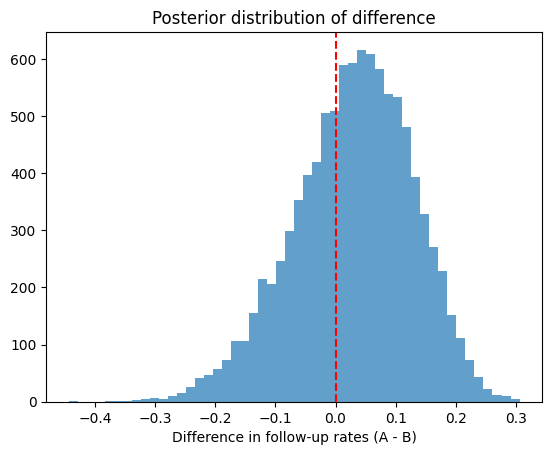

In [5]:
# Probability that DrB is better, i.e. (pB < pA)
prob_B_better = np.mean(pB_samples < pA_samples)
print(f"Probability Doctor B better (lower follow-up): {prob_B_better:.3f}")

# Difference samples
diff_samples = pA_samples - pB_samples  # if positive, DrA is better

# Plot distribution of difference
plt.hist(diff_samples, bins=50, alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Difference in follow-up rates (A - B)')
plt.title('Posterior distribution of difference')
plt.show()

---
# III. Resampling (Bootstrap): focus on small sample size

__Idea:__ estimate the distribution of a statistic by resampling with replacement.
We'll use bootstrap on Doctor B's small sample to:
- Understand the variability in the estimated follow-up rate.
- Estimate a CI for DrB's rate without relying on normal approximation.

__It's useful, because it:__
- Works well for small or non-normal samples.
- Doesn’t assume any distribution — it builds one empirically.
- Helps stabilize the inference when analytical CIs are unreliable due to low sample size.

Bootstrap 95% CI for Doctor B's follow-up rate: [0.100, 0.450]
Bootstrap mean rate: 0.250


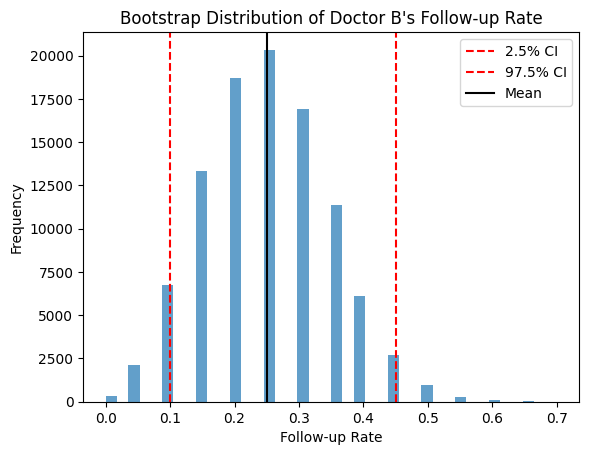

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Doctor B: 5 follow-ups out of 20
original_data_B = np.array([1]*5 + [0]*15)  # 1 = need a follow-up surgery, 0 = successful surgery
nB = len(original_data_B)

# Bootstrap
N_bootstrap = 100_000
boot_means = np.empty(N_bootstrap)

for i in range(N_bootstrap):
    resample = np.random.choice(original_data_B, size=nB, replace=True)
    boot_means[i] = np.mean(resample)

# Bootstrap CI (e.g., 95%)
lower, upper = np.percentile(boot_means, [2.5, 97.5])

print(f"Bootstrap 95% CI for Doctor B's follow-up rate: [{lower:.3f}, {upper:.3f}]")
print(f"Bootstrap mean rate: {np.mean(boot_means):.3f}")

# Plot
plt.hist(boot_means, bins=40, alpha=0.7)
plt.axvline(lower, color='red', linestyle='--', label='2.5% CI')
plt.axvline(upper, color='red', linestyle='--', label='97.5% CI')
plt.axvline(np.mean(boot_means), color='black', linestyle='-', label='Mean')
plt.title("Bootstrap Distribution of Doctor B's Follow-up Rate")
plt.xlabel("Follow-up Rate")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Summary:
We can visually inspect the variability of the observed mean for Doctor B, assuming the true rate of 25%.

It's clear that the 2.5%-97.5% <span style="color:red">CI is relatively wide (from 0.1 to 0.45) in comparison to the 5% difference between<span> the observed failure rate between Docotors' A and B.

---
# IV. Simulation

### Reasons for a Simulation
- Analytical formulas assume **asymptotic normality**, which may be shaky for small samples (Doctor B).
- Simulation lets us see **empirical coverage**, **CI width**, and the effect of **imbalance**.

### Define parameters from your data

| Doctor | True follow-up rate (estimate) | Sample size |
|--------|--------------------------------|-------------|
| A      | 0.30                           | 200         |
| B      | 0.25                           | 20          |

### Simulation plan
For $N$ iterations (e.g., 10,000):
1) Draw $X_A \sim \text{Binomial}(200, 0.30)$
2) Draw $X_B \sim \text{Binomial}(20, 0.25)$
3) Compute sample proportions $\hat{p}_A, \hat{p}_B$
4) Compute difference $\hat{d} = \hat{p}_A - \hat{p}_B$
5) Compute 95% confidence interval for difference using standard formula:
$$\hat{d} \pm 1.96 \times \sqrt{\frac{\hat{p}_A (1 - \hat{p}_A)}{n_A} + \frac{\hat{p}_B (1 - \hat{p}_B)}{n_B}}$$
6) Check if CI contains 0 (no difference)

### Post-simulation analysis
- Calculate proportion of CIs that contain 0 (coverage)
- Plot distribution of $\hat{d}$ and widths of confidence intervals

Proportion of CIs containing 0 (coverage): 0.864
Mean CI width: 0.387


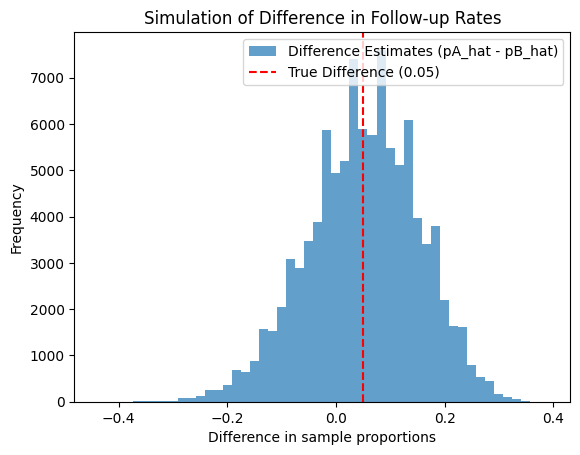

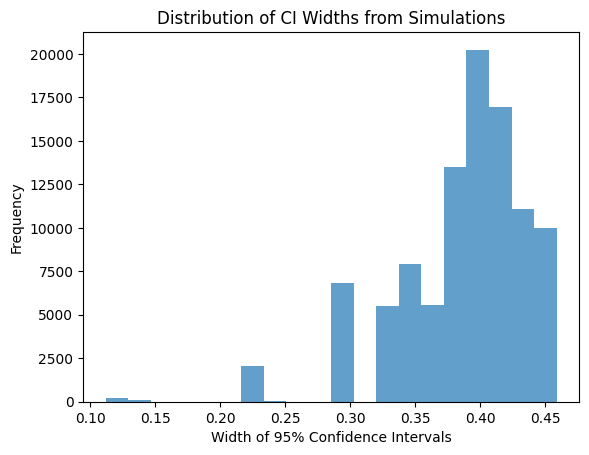

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
pA_true, nA = 0.30, 200
pB_true, nB = 0.25, 20
N_sim = 100_000

diffs = np.empty(N_sim)
ci_widths = np.empty(N_sim)
contains_zero = np.empty(N_sim, dtype=bool)

for i in range(N_sim):
    xA = np.random.binomial(nA, pA_true)
    xB = np.random.binomial(nB, pB_true)
    pA_hat = xA / nA
    pB_hat = xB / nB
    diff = pA_hat - pB_hat
    se = np.sqrt(pA_hat * (1 - pA_hat) / nA + pB_hat * (1 - pB_hat) / nB)
    lower = diff - 1.96 * se
    upper = diff + 1.96 * se
    
    diffs[i] = diff
    ci_widths[i] = upper - lower
    contains_zero[i] = (lower <= 0) and (upper >= 0)

coverage = np.mean(contains_zero)

print(f"Proportion of CIs containing 0 (coverage): {coverage:.3f}")
print(f"Mean CI width: {np.mean(ci_widths):.3f}")

# Plot histogram of difference estimates
plt.hist(diffs, bins=50, alpha=0.7, label='Difference Estimates (pA_hat - pB_hat)')
plt.axvline(pA_true - pB_true, color='red', linestyle='--', label='True Difference (0.05)')
plt.xlabel('Difference in sample proportions')
plt.ylabel('Frequency')
plt.legend()
plt.title('Simulation of Difference in Follow-up Rates')
plt.show()

# Plot histogram of CI widths
plt.hist(ci_widths, bins=20, alpha=0.7)
plt.xlabel('Width of 95% Confidence Intervals')
plt.ylabel('Frequency')
plt.title('Distribution of CI Widths from Simulations')
plt.show()

### Summary:
- CIs tend to be wide, because of Doctor B's small sample size
- 87% of CIs contain 0; since true difference is 0.05, this high coverage means <span style="color:red">cautious inference</span>